In [1]:
import os
import cv2
import numpy as np
import config as cfg
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


In [2]:
'''
    load image data to the list.
    Args:
        data_path (str)
    Returns:
        faces (list): extracted faces from images
        ids (list): label encoding of the faces.
        label_dc (dict): key -> id, value -> name
'''
def load_data(data_path):
    faces = list()
    ids = list()
    label_dc = dict()
    for i, dirs in enumerate(tqdm(os.listdir(data_path))):
        label_dc[i] = dirs
        full_path = os.path.join(data_path, dirs)
        for image_path in os.listdir(full_path):
            face = extract_faces(os.path.join(full_path, image_path), cfg.HAARCASCADE_PATH)
            if face is None:
                continue
            face = cv2.resize(face, dsize=(160, 160))
            faces.append(face[..., :3])
            ids.append(i)
    label_dc[len(label_dc)] = 'Unknown'
    print('\ndata has been loaded')

    return faces, ids, label_dc

In [3]:
'''
face detection using Haar cascade
'''
def extract_faces(image_path, cascade_path):
    '''
        extract faces using opencv haar cascade classifer
        Args:
            image_path (str)
            cascade_path (str)
        Returns:
            img[y:y+h,x:x+w] (np.array): extracted face from image
    '''
    face_cascade = cv2.CascadeClassifier(cascade_path)
    img = plt.imread(image_path)
    face_sample = face_cascade.detectMultiScale(img, 1.1, 4)
    for (x,y,w,h) in (face_sample):
            return img[y:y+h,x:x+w]

faces, ids, label_dc = load_data(cfg.DATA_PATH)


100%|██████████| 2/2 [00:01<00:00,  1.78it/s]
data has been loaded



In [4]:
'''
    get 128D embeeding using facenet model
    Args:
        model (str): loaded .h5 file
        face_pixels (np.array): extracted face pixels
    Returns:
        yhat[0] (128D vector): generated embedding using model  
'''
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]


model = load_model(cfg.MODEL_PATH)

In [5]:
'''
    prepare data for training
'''
train_x = list()
for face in faces:
    embedding = get_embedding(model, face)
    train_x.append(embedding)
train_x = np.array(train_x)
train_x.shape

(21, 128)

In [6]:
from matplotlib import pyplot
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [7]:
'''
 Normalize embeddings using L2 according to paper. Make one-hot encoding over labels.
'''
in_encoder = Normalizer(norm='l2')
train_x = in_encoder.transform(train_x)
labels = OneHotEncoder(sparse=False).fit_transform(np.array(ids).reshape(-1, 1))

In [17]:
'''
  build a neural network to classify names from face embeddings
'''
from keras.layers import Dense
from keras.models import Sequential

if len(label_dc) - 1 == 2:
  loss = 'binary_crossentropy'
  activation = 'sigmoid'
else:
  loss = 'categorical_crossentropy'
  activation = 'softmax'

final_model = Sequential([
  Dense(64, activation='relu', input_shape=(128,)),
  Dense(64, activation='relu'),
  Dense(len(label_dc) - 1, activation=activation),
  ])

final_model.compile('adam', loss)
final_model.fit(train_x, labels, epochs=100)

Epoch 1/100
21/21 [==============================] - 0s 3ms/step - loss: 0.6712
Epoch 2/100
21/21 [==============================] - 0s 63us/step - loss: 0.6604
Epoch 3/100
21/21 [==============================] - 0s 70us/step - loss: 0.6495
Epoch 4/100
21/21 [==============================] - 0s 88us/step - loss: 0.6386
Epoch 5/100
21/21 [==============================] - 0s 91us/step - loss: 0.6276
Epoch 6/100
21/21 [==============================] - 0s 70us/step - loss: 0.6167
Epoch 7/100
21/21 [==============================] - 0s 75us/step - loss: 0.6056
Epoch 8/100
21/21 [==============================] - 0s 85us/step - loss: 0.5941
Epoch 9/100
21/21 [==============================] - 0s 71us/step - loss: 0.5824
Epoch 10/100
21/21 [==============================] - 0s 134us/step - loss: 0.5701
Epoch 11/100
21/21 [==============================] - 0s 68us/step - loss: 0.5573
Epoch 12/100
21/21 [==============================] - 0s 57us/step - loss: 0.5441
Epoch 13/100
21/21 [=====

In [19]:
def predict(img, fnl_model):
    '''
        Args:
            img (np.array)
            fnl_model (.h5)
        Returns:
            faces (np.array): detected faces using haarcascade
            predictions (np.array): model prediction
    '''
    face_cascade = cv2.CascadeClassifier(cfg.HAARCASCADE_PATH)
    faces = face_cascade.detectMultiScale( 
        image,
        scaleFactor = 1.2,
        minNeighbors = 5)
    test_x = list()
    for(x,y,w,h) in faces:
        face = cv2.resize(img[y:y+h, x:x+w], (160, 160))
        embedded = get_embedding(model, face)
        test_x.append(embedded)
    in_encoder = Normalizer(norm='l2')
    test_x = in_encoder.transform(test_x)
    predictions = fnl_model.predict(test_x)
  
    return faces, predictions

In [20]:
image_path = os.path.join(cfg.TEST_DATA_PATH, 'Elon_Musk_Steve_Jobs.jpg')
image = plt.imread(image_path)
faces, predictions = predict(image, final_model)

In [21]:
def plot_result(image, faces, predictions, dc, thresh):
    '''
        Args:
            image (np.array): test image
            faces (np.aray): extracted faces
            predictions (np.array): model prediction
            dc (dict): key -> id, value -> name
            thresh (int): threshold value
    '''
    for(x,y,w,h), ids in zip(faces, predictions):
        result = np.amax(ids)
        index  = np.argmax(ids)
        if result >= thresh:
            _id = index
        else:
            _id = len(dc) - 1
        cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0), 2)
        cv2.putText(image, dc[_id], (x+5,y-5), cv2.FONT_HERSHEY_SIMPLEX, 1, color = (255, 0, 255), thickness = 2)
    plt.figure(figsize=(15, 15))   
    plt.imshow(image)


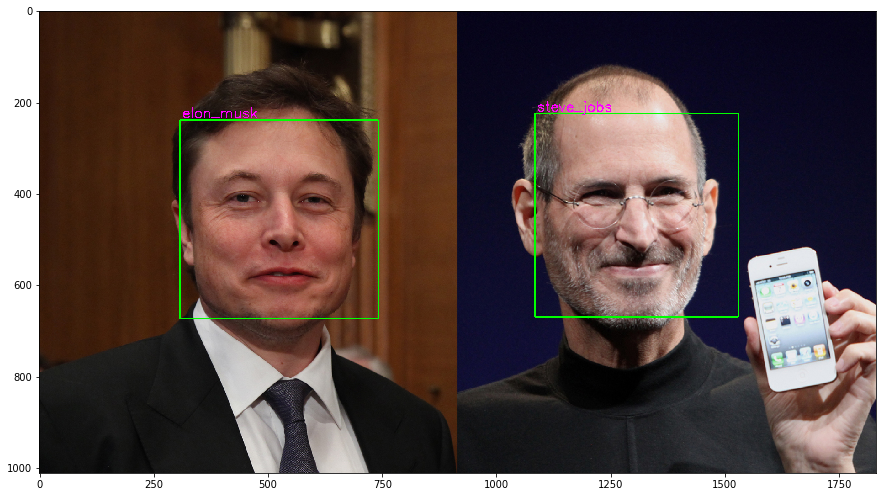

In [22]:
plot_result(image, faces, predictions, label_dc, 0.90)

In [23]:
predictions

array([[0.00362196, 0.9966685 ],
       [0.99886096, 0.00213768]], dtype=float32)